In [1]:
import pandas as pd 
import os

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"
datasets = []
for f in os.listdir(TICKER_DIR):
    df = pd.read_csv(f, header=0)
    datasets.append(df)

# dataset1 = pd.read_csv(f"{TICKER_DIR}\\MA_ARD.csv", header=0)
# dataset2 = pd.read_csv(f"{TICKER_DIR}\\MA_AIZP.csv", header=0)
print(dataset1.shape)
print(dataset2.shape)
dataset = pd.concat([dataset1, dataset2])
dataset = dataset.dropna(how="any")
dataset

(232, 11)
(187, 11)


,close,high,low,open,volume,R.Mean,R.std,S0%k,EMA,BolBand1,BolBand2
13,19.99,20.11,19.9600,20.08,34886,20.572143,0.422050,0.000000,20.356228,0.082062,0.155169
14,20.24,20.37,19.9500,19.95,65774,20.515000,0.407747,21.739130,20.338680,0.079502,0.331391
15,19.90,20.37,19.8400,20.20,120148,20.426429,0.396050,0.000000,20.273596,0.077556,0.167701
16,20.10,20.22,19.8600,19.89,49061,20.366429,0.375348,18.018018,20.248222,0.073719,0.322546
17,20.18,20.36,20.0707,20.20,15931,20.307857,0.330132,25.225225,20.238376,0.065026,0.403177
...,...,...,...,...,...,...,...,...,...,...,...
182,107.87,107.87,106.6700,106.67,1377,108.317857,1.872786,37.064220,107.658271,0.069159,0.440215
183,106.61,107.12,106.6100,107.12,14200,108.332857,1.857018,13.944954,107.518502,0.068567,0.268061
184,106.66,106.84,104.0300,105.85,18721,108.095000,1.841633,14.862385,107.404035,0.068149,0.305200
185,105.00,105.00,105.0000,105.00,25240,107.738571,1.927541,0.000000,107.083497,0.071564,0.144810


In [2]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

values = dataset.to_numpy()

scaler = StandardScaler()
scaled = scaler.fit_transform(values)

X = scaled[:][:-154] # 11 features * 14 days 
y = scaled[:, 0][154:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
timesteps = 14
train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(X_test, y_test, length=timesteps, sampling_rate=1, batch_size=timesteps)

Using TensorFlow backend.


In [3]:
X_train, y_train = train_generator[0]
X_test, y_test = test_generator[0]

train_samples = X_train.shape[0] * len(train_generator)
test_samples = X_test.shape[0] * len(test_generator)

In [4]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU

units = 128
epochs = 100
learning_rate = 0.001
x_shape = X_train.shape
print(x_shape)
model = Sequential()
model.add(LSTM(units, input_shape=(x_shape[1], x_shape[2])))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(1))

adam = Adam(lr=learning_rate)
model.compile(loss="mse", optimizer=adam, metrics=["mae"])

history = model.fit_generator(train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    verbose=1,
    shuffle=False,
    initial_epoch=0)

score = model.evaluate_generator(test_generator, verbose=0)

(14, 14, 11)
Epoch 1/100
13/13 [==============================] - 0s 34ms/step - loss: 0.9371 - mae: 0.8714 - val_loss: 0.7195 - val_mae: 0.7872
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.9019 - mae: 0.8818 - val_loss: 0.6325 - val_mae: 0.6872
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8942 - mae: 0.8490 - val_loss: 0.6666 - val_mae: 0.7345
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8715 - mae: 0.8510 - val_loss: 0.6297 - val_mae: 0.6853
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8663 - mae: 0.8388 - val_loss: 0.6424 - val_mae: 0.6992
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8534 - mae: 0.8335 - val_loss: 0.6252 - val_mae: 0.6719
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8586 - mae: 0.8304 - val_loss: 0.6266 - val_mae: 0.6745
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - lo

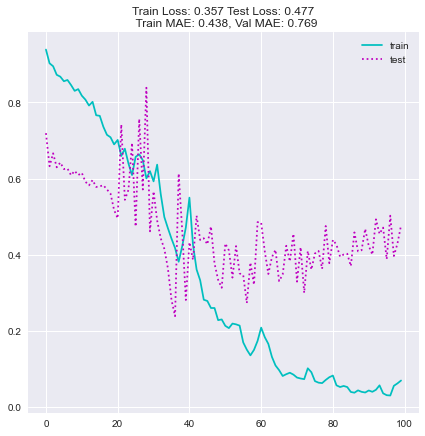

In [5]:
import matplotlib.pyplot as plt 

train_loss = np.mean(history.history["loss"])
train_mae = np.mean(history.history["mae"])
title = f'Train Loss: {train_loss:.3f} Test Loss: {score[0]:.3f}\n  Train MAE: {train_mae:.3f}, Val MAE: {score[1]:.3f}'
fig = plt.figure()
plt.style.use("seaborn")
plt.plot(history.history["loss"], "c-", label="train")
plt.plot(history.history["val_loss"], "m:", label="test")
plt.title(title)
plt.legend()
fig.set_size_inches(w=7, h=7)
plt.close()
display(fig)

In [9]:
test_predict = model.predict(y_test, batch_size=14)

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (14, 1)